In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-accidents/US_Accidents_June20.csv


In [98]:
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
import io
from scipy.stats import boxcox

## Overview and preprocessing

In [99]:
df=pd.read_csv('/kaggle/input/us-accidents/US_Accidents_June20.csv')

In [100]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [101]:
df.Severity.value_counts()

2    2373210
3     998913
4     112320
1      29174
Name: Severity, dtype: int64

In [102]:
df.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [103]:
df.shape

(3513617, 49)

### Sources

In [104]:
df_source=df.groupby(['Severity','Source']).size().reset_index()
df_source

,Severity,Source,0
0,1,Bing,28106
1,1,MapQuest,1049
2,1,MapQuest-Bing,19
3,2,Bing,740299
4,2,MapQuest,1593276
5,2,MapQuest-Bing,39635
6,3,Bing,160904
7,3,MapQuest,813206
8,3,MapQuest-Bing,24803
9,4,Bing,105490


In [105]:
df_source=df_source.pivot(columns='Severity', index='Source', values=0)
df_source

Severity,1,2,3,4
Source,,,,
Bing,28106,740299,160904,105490
MapQuest,1049,1593276,813206,6770
MapQuest-Bing,19,39635,24803,60


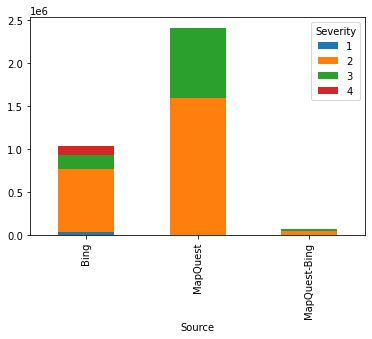

In [106]:
df_source.plot(kind='bar', stacked='True')

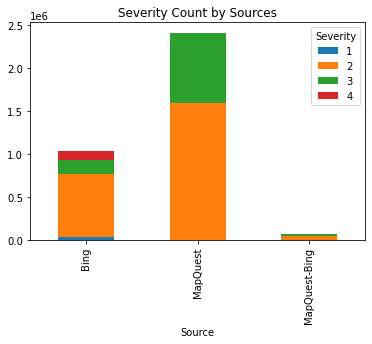

In [107]:
df_source.plot(kind='bar', stacked='True', title='Severity Count by Sources')

In [108]:
# fix datetime
df['Start_Time']=pd.to_datetime(df['Start_Time'])
df['End_Time']=pd.to_datetime(df['End_Time'])
df['Weather_Timestamp']=pd.to_datetime(df['Weather_Timestamp'])

df['Duration']=df.End_Time-df.Start_Time
df['Duration']=df['Duration'].apply(lambda x: round (x.total_seconds()/60))
print('overall mean duration:', (round(df['Duration'].mean())), 'min')

overall mean duration: 115 min


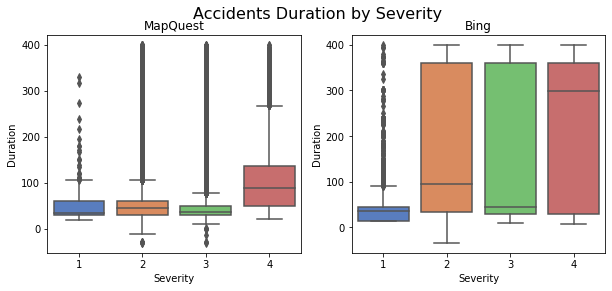

In [109]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.boxplot(x="Severity", y="Duration",
            data=df.loc[(df['Source']=="MapQuest") & (df['Duration']<400),], palette="muted", ax=axs[0])
axs[0].set_title('MapQuest')
fig.suptitle('Accidents Duration by Severity', fontsize=16)
sns.boxplot(x="Severity", y="Duration",
            data=df.loc[(df['Source']=="Bing") & (df['Duration']<400),], palette="muted", ax=axs[1])
axs[1].set_title('Bing')
plt.show()

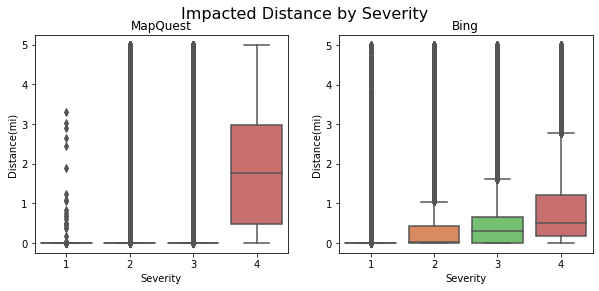

In [110]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.boxplot(x="Severity", y="Distance(mi)", 
            data=df.loc[(df['Source']=="MapQuest") & (df['Distance(mi)']<5),], palette="muted", ax=axs[0])
axs[0].set_title('MapQuest')
fig.suptitle('Impacted Distance by Severity', fontsize=16)
sns.boxplot(x="Severity", y="Distance(mi)",
            data=df.loc[(df['Source']=="Bing") & (df['Distance(mi)']<5),], palette="muted", ax=axs[1])
axs[1].set_title('Bing')
plt.show()

In [111]:
df = df.loc[df['Source']=="MapQuest",]
df = df.drop(['Source'], axis=1)

### useless features

In [112]:
df = df.drop(['ID','TMC','Description','Distance(mi)', 'End_Time', 'Duration', 
              'End_Lat', 'End_Lng'], axis=1)

In [113]:
cat_names = ['Side', 'Country', 'Timezone', 'Amenity', 'Bump', 'Crossing', 
             'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 
             'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 
             'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
print("Unique count of categorical features:")
for i in cat_names:
    print(i,df[i].unique().size)

Unique count of categorical features:
Side 3
Country 1
Timezone 5
Amenity 2
Bump 2
Crossing 2
Give_Way 2
Junction 2
No_Exit 2
Railway 2
Roundabout 2
Station 2
Stop 2
Traffic_Calming 2
Traffic_Signal 2
Turning_Loop 1
Sunrise_Sunset 3
Civil_Twilight 3
Nautical_Twilight 3
Astronomical_Twilight 3


In [114]:
df = df.drop(['Country','Turning_Loop'], axis=1)

### cleaning up

In [115]:
# wind direction
df['Wind_Direction'].unique()

array(['Calm', 'SW', 'SSW', 'WSW', 'WNW', 'NW', 'West', 'NNW', 'NNE',
       'South', 'North', 'Variable', 'SE', 'SSE', 'ESE', 'East', 'NE',
       'ENE', 'E', 'W', nan, 'S', 'VAR', 'CALM', 'N'], dtype=object)

In [116]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['CALM' 'SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE' nan]


In [117]:
#weather condition
df['Weather_Condition'].unique()

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Rain', 'Light Snow',
       'Haze', 'Scattered Clouds', 'Partly Cloudy', 'Clear', 'Snow',
       'Light Freezing Drizzle', 'Light Drizzle', 'Fog', 'Shallow Fog',
       'Heavy Rain', 'Light Freezing Rain', 'Cloudy', 'Drizzle', nan,
       'Light Rain Showers', 'Mist', 'Smoke', 'Patches of Fog',
       'Light Freezing Fog', 'Light Haze', 'Light Thunderstorms and Rain',
       'Thunderstorms and Rain', 'Fair', 'Volcanic Ash', 'Blowing Sand',
       'Blowing Dust / Windy', 'Widespread Dust', 'Fair / Windy',
       'Rain Showers', 'Mostly Cloudy / Windy', 'Light Rain / Windy',
       'Hail', 'Heavy Drizzle', 'Showers in the Vicinity', 'Thunderstorm',
       'Light Rain Shower', 'Light Rain with Thunder',
       'Partly Cloudy / Windy', 'Thunder in the Vicinity', 'T-Storm',
       'Heavy Thunderstorms and Rain', 'Thunder', 'Heavy T-Storm',
       'Funnel Cloud', 'Heavy T-Storm / Windy', 'Blowing Snow',
       'Light Thunderstorms and Snow',

In [118]:
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear|Fair', case=False, na = False), 1, 0)
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), 1, 0)
df['Rain'] = np.where(df['Weather_Condition'].str.contains('Rain|Storm|Drizzle', case=False, na = False), 1, 0)
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms|Thunderstorm', case=False, na = False), 1, 0)
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), 1, 0)
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls|Hail', case=False, na = False), 1, 0)
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog|Haze|Dust|Smoke|Ash', case=False, na = False), 1, 0)
df['Wind'] = np.where(df['Weather_Condition'].str.contains('Wind', case=False, na = False), 1, 0)
# Assign NA to created weather features where 'Weather_Condition' is null.
weather = ['Clear','Cloud','Rain','Heavy_Rain','Snow','Heavy_Snow','Fog','Wind']
for i in weather:
    
    df.loc[df['Weather_Condition'].isnull(),i] = df.loc[df['Weather_Condition'].isnull(),'Weather_Condition']

df.loc[:,['Weather_Condition'] + weather]

df = df.drop(['Weather_Condition'], axis=1)

In [119]:
#df.loc[df['Weather_Condition']=='T-Storm / Windy']

In [120]:
# fix datetime format
print("Mean difference between 'Start_Time' and 'Weather_Timestamp': ", 
(df.Weather_Timestamp - df.Start_Time).mean())

Mean difference between 'Start_Time' and 'Weather_Timestamp':  0 days 00:00:30.397947930


In [121]:
#df['Source'].unique()

In [122]:
df = df.drop(["Weather_Timestamp"], axis=1)

df['Year'] = df['Start_Time'].dt.year

nmonth = df['Start_Time'].dt.month
df['Month'] = nmonth

df['Weekday']= df['Start_Time'].dt.weekday

days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
nday = [days_each_month[arg-1] for arg in nmonth.values]
nday = nday + df["Start_Time"].dt.day.values
df['Day'] = nday

df['Hour'] = df['Start_Time'].dt.hour

df['Minute']=df['Hour']*60.0+df["Start_Time"].dt.minute

df.loc[:4,['Start_Time', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']]

,Start_Time,Year,Month,Weekday,Day,Hour,Minute
0,2016-02-08 05:46:00,2016,2,0,39,5,346.0
1,2016-02-08 06:07:59,2016,2,0,39,6,367.0
2,2016-02-08 06:49:27,2016,2,0,39,6,409.0
3,2016-02-08 07:23:34,2016,2,0,39,7,443.0
4,2016-02-08 07:39:07,2016,2,0,39,7,459.0


### missing data

In [123]:
df.isnull().sum()

Severity                       0
Start_Time                     0
Start_Lat                      0
Start_Lng                      0
Number                   1445664
Street                         0
Side                           0
City                          50
County                         0
State                          0
Zipcode                      310
Timezone                    2061
Airport_Code                4125
Temperature(F)             39453
Wind_Chill(F)            1417631
Humidity(%)                42060
Pressure(in)               33897
Visibility(mi)             47554
Wind_Direction             33964
Wind_Speed(mph)           338278
Precipitation(in)        1518773
Amenity                        0
Bump                           0
Crossing                       0
Give_Way                       0
Junction                       0
No_Exit                        0
Railway                        0
Roundabout                     0
Station                        0
Stop      

In [124]:
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Percent(%)']
missing['Missing_Percent(%)'] = missing['Missing_Percent(%)'].apply(lambda x: x / df.shape[0] * 100)
missing.loc[missing['Missing_Percent(%)']>0,:]

,Feature,Missing_Percent(%)
4,Number,59.879195
7,City,0.002071
10,Zipcode,0.012840
11,Timezone,0.085366
12,Airport_Code,0.170857
13,Temperature(F),1.634138
14,Wind_Chill(F),58.718072
15,Humidity(%),1.742119
16,Pressure(in),1.404009
17,Visibility(mi),1.969680


In [125]:
df = df.drop(['Number','Wind_Chill(F)','Precipitation(in)'], axis=1)
#df = df.drop(['Precipitation_NA'], axis=1)

In [126]:
# df['Precipitation_NA'] = 0
# df.loc[df['Precipitation(in)'].isnull(),'Precipitation_NA'] = 1
# df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())
# df.loc[:5,['Precipitation(in)','Precipitation_NA']]

In [127]:
df = df.dropna(subset=['City','Zipcode','Airport_Code',
                       'Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'])

In [128]:
# group data by 'Airport_Code' and 'Start_Month' then fill NAs with median value
Weather_data=['Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)']
print("The number of remaining missing values: ")
for i in Weather_data:
    
    df[i] = df.groupby(['Airport_Code','Month'])[i].apply(lambda x: x.fillna(x.median()))
    print( i + " : " + df[i].isnull().sum().astype(str))

The number of remaining missing values: 
Temperature(F) : 4899
Humidity(%) : 4924
Pressure(in) : 4865
Visibility(mi) : 11084
Wind_Speed(mph) : 11257


In [129]:
df = df.dropna(subset=Weather_data)

In [130]:
# group data by 'Airport_Code' and 'Start_Month' then fill NAs with majority value
from collections import Counter
weather_cat = ['Wind_Direction'] + weather
print("Count of missing values that will be dropped: ")
for i in weather_cat:
    df[i] = df.groupby(['Airport_Code','Month'])[i].apply(lambda x: x.fillna(Counter(x).most_common()[0][0]) if all(x.isnull())==False else x)
    print(i + " : " + df[i].isnull().sum().astype(str))

Count of missing values that will be dropped: 
Wind_Direction : 7999
Clear : 11660
Cloud : 11276
Rain : 9561
Heavy_Rain : 8940
Snow : 8963
Heavy_Snow : 8932
Fog : 9037
Wind : 9002


In [131]:
# drop na
df = df.dropna(subset=weather_cat)

### Exploration and Engineering

In [132]:
df['Severity4'] = 0
df.loc[df['Severity'] == 4, 'Severity4'] = 1
#df.loc[df['Severity'] == 3, 'Severity4'] = 1
df.Severity4.value_counts()

0    2377729
1       6615
Name: Severity4, dtype: int64

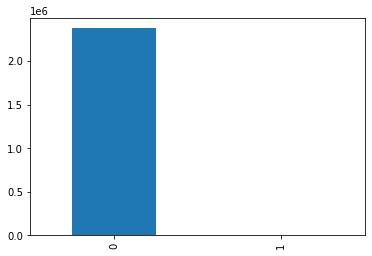

In [133]:
df['Severity4'].value_counts().plot.bar()

In [134]:
df = df.drop(['Severity'], axis = 1)
df_bl = pd.concat([df[df['Severity4']==1].sample(100000, replace = True),
                   df[df['Severity4']==0].sample(100000)], axis=0)
print('resampled data:', df_bl.Severity4.value_counts())

resampled data: 1    100000
0    100000
Name: Severity4, dtype: int64


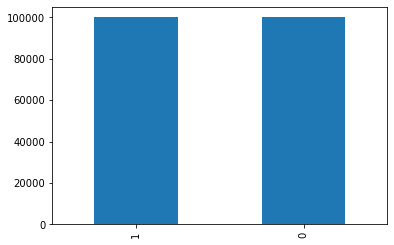

In [135]:
df_bl['Severity4'].value_counts().plot.bar()

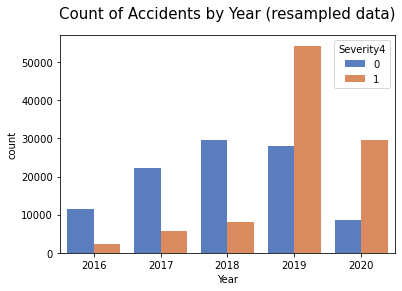

In [136]:
# time features
# year
df_bl.Year = df_bl.Year.astype(str)
sns.countplot(x='Year', hue='Severity4', data=df_bl ,palette="muted")
plt.title('Count of Accidents by Year (resampled data)', size=15, y=1.05)
plt.show()

In [141]:
#groups

In [142]:
# df = df.loc[(df['Year']==2019) | (df['Year']==2020),:]
df = df.drop(['Year', 'Start_Time'], axis=1)
df['Severity4'].value_counts()

0    2377729
1       6615
Name: Severity4, dtype: int64

In [143]:
#street

# create a list of top 40 most common words in street name
st_type =' '.join(df['Street'].unique().tolist()) # flat the array of street name
st_type = re.split(" |-", st_type) # split the long string by space and hyphen
st_type = [x[0] for x in Counter(st_type).most_common(40)] # select the 40 most common words
print('the 40 most common words')
print(*st_type, sep = ", ") 

the 40 most common words
Rd, Dr, St, Ave, N, S, E, W, Ln, Blvd, Way, Ct, Highway, Pl, Pkwy, NE, SW, Hwy, Cir, SE, NW, Old, State, Road, Creek, Hill, Park, Lake, County, Route, US, Trl, Valley, Ridge, Mill, Ter, I, Oak, River, Loop


In [144]:
# Remove some irrelevant words and add spaces and hyphen back
st_type= [' Rd', ' St', ' Dr', ' Ave', ' Blvd', ' Ln', ' Highway', ' Pkwy', ' Hwy', 
          ' Way', ' Ct', 'Pl', ' Road', 'US-', 'Creek', ' Cir', 'Hill', 'Route', 
          'I-', 'Trl', 'Valley', 'Ridge', 'Pike', ' Fwy', 'River']
print(*st_type, sep = ", ")  

 Rd,  St,  Dr,  Ave,  Blvd,  Ln,  Highway,  Pkwy,  Hwy,  Way,  Ct, Pl,  Road, US-, Creek,  Cir, Hill, Route, I-, Trl, Valley, Ridge, Pike,  Fwy, River


In [145]:
# for each word create a boolean column
for i in st_type:
    df[i.strip()] = np.where(df['Street'].str.contains(i, case=True, na = False), 1, 0)
df.loc[df['Road']==1,'Rd'] = 1
df.loc[df['Highway']==1,'Hwy'] = 1

# # resample again
# df_bl = pd.concat([df[df['Severity4']==1].sample(40000, replace = True), 
#                    df[df['Severity4']==0].sample(40000)], axis=0)

# # plot correlation
# df_bl['Severity4'] = df_bl['Severity4'].astype(int)
# street_corr  = df_bl.loc[:,['Severity4']+[x.strip() for x in st_type]].corr()
# plt.figure(figsize=(20,15))
# cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
# sns.heatmap(street_corr, annot=True, cmap=cmap, center=0).set_title("Correlation (resampled data)", fontsize=16)
# plt.show()

In [146]:
#df['Road']

In [147]:
#df['State']

In [148]:
# # resample again
df_bl = pd.concat([df[df['Severity4']==1].sample(100000, replace = True), 
                   df[df['Severity4']==0].sample(100000)], axis=0)

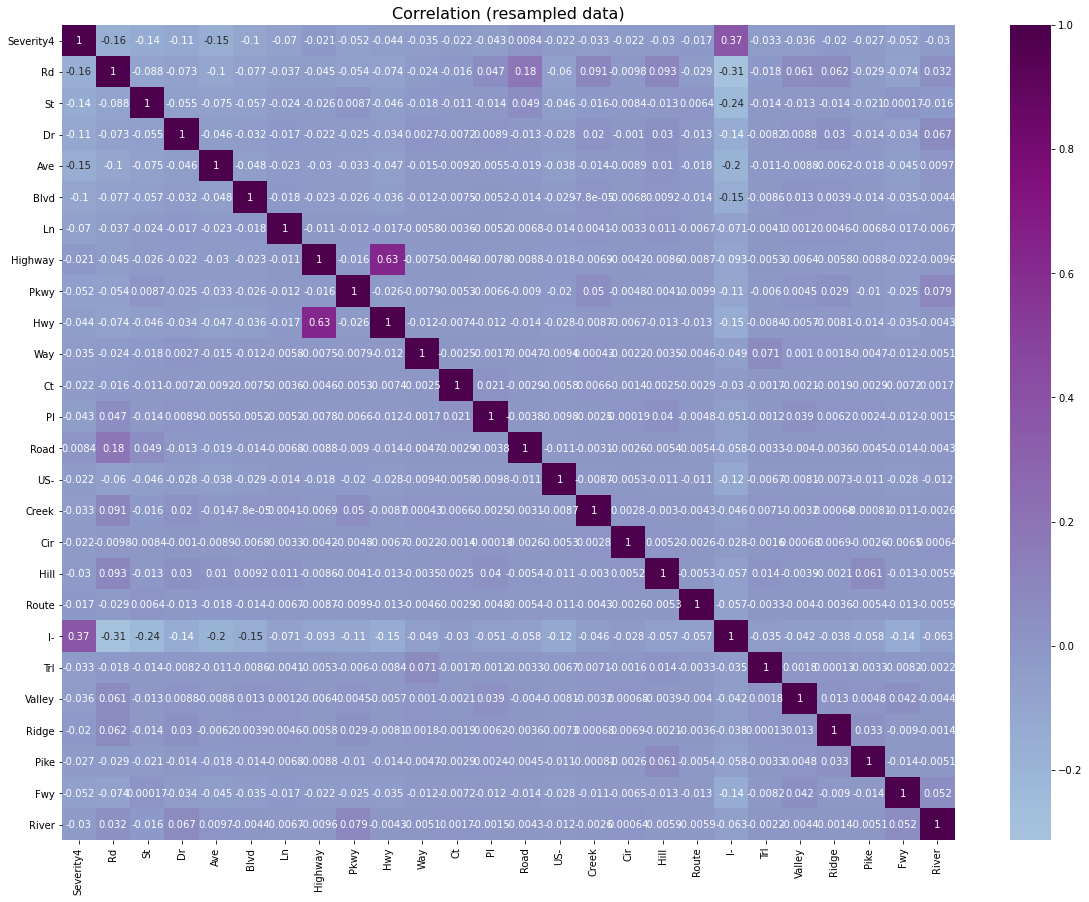

In [149]:
# plot correlation
df_bl['Severity4'] = df_bl['Severity4'].astype(int)
street_corr  = df_bl.loc[:,['Severity4']+[x.strip() for x in st_type]].corr()
plt.figure(figsize=(20,15))
#cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(street_corr, annot=True, cmap='BuPu', center=0).set_title("Correlation (resampled data)", fontsize=16)
plt.show()

In [150]:
drop_list = street_corr.index[street_corr['Severity4'].abs()<0.1].to_list()
df = df.drop(drop_list, axis=1)


In [151]:
# # resample again
df_bl = pd.concat([df[df['Severity4']==1].sample(100000, replace = True), 
                   df[df['Severity4']==0].sample(100000)], axis=0)

In [152]:
df.head()

,Start_Lat,Start_Lng,Street,Side,City,County,State,Zipcode,Timezone,Airport_Code,...,Day,Hour,Minute,Severity4,Rd,St,Dr,Ave,Blvd,I-
0,39.865147,-84.058723,I-70 E,R,Dayton,Montgomery,OH,45424,US/Eastern,KFFO,...,39,5,346.0,0,0,0,0,0,0,1
1,39.928059,-82.831184,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US/Eastern,KCMH,...,39,6,367.0,0,1,0,0,0,0,0
2,39.063148,-84.032608,State Route 32,R,Williamsburg,Clermont,OH,45176,US/Eastern,KI69,...,39,6,409.0,0,0,0,0,0,0,0
3,39.747753,-84.205582,I-75 S,R,Dayton,Montgomery,OH,45417,US/Eastern,KDAY,...,39,7,443.0,0,0,0,0,0,0,1
4,39.627781,-84.188354,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US/Eastern,KMGY,...,39,7,459.0,0,1,0,0,0,0,0


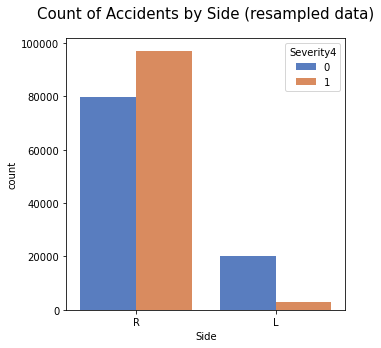

In [153]:
# side
plt.figure(figsize=(5,5))
chart = sns.countplot(x='Side', hue='Severity4', data=df_bl ,palette="muted")
plt.title("Count of Accidents by Side (resampled data)", size=15, y=1.05)
plt.show()

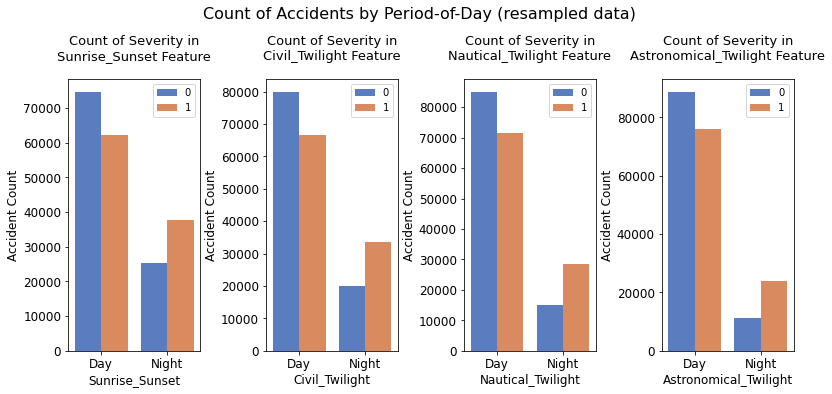

In [154]:
# time

# period of day

period_features = ['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(13, 5))

plt.subplots_adjust(wspace = 0.5)
for i, feature in enumerate(period_features, 1):    
    plt.subplot(1, 4, i)
    sns.countplot(x=feature, hue='Severity4', data=df_bl ,palette="muted")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(['0', '1'], loc='upper right', prop={'size': 10})
    plt.title('Count of Severity in\n{} Feature'.format(feature), size=13, y=1.05)
fig.suptitle('Count of Accidents by Period-of-Day (resampled data)',y=1.08, fontsize=16)
plt.show()

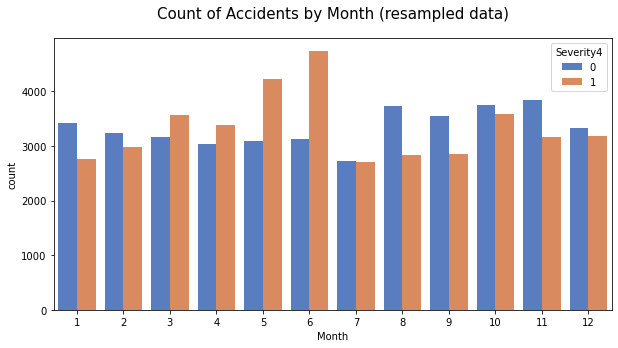

In [81]:
#month
plt.figure(figsize=(10,5))
sns.countplot(x='Month', hue='Severity4', data=df_bl ,palette="muted")
plt.title('Count of Accidents by Month (resampled data)', size=15, y=1.05)
plt.show()

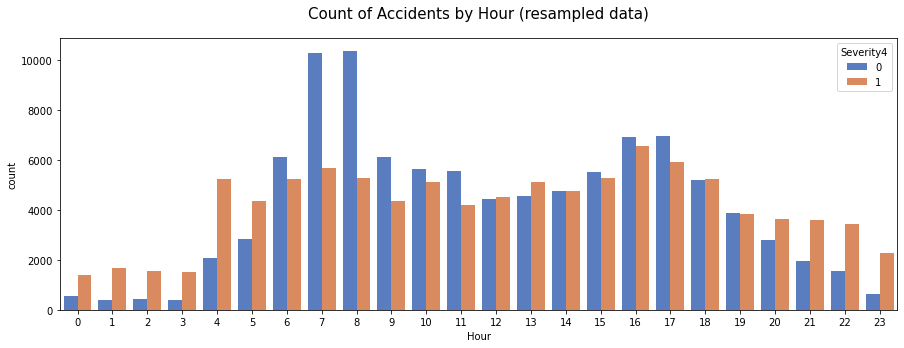

In [155]:
# hour
plt.figure(figsize=(15,5))
sns.countplot(x='Hour', hue='Severity4', data=df_bl ,palette="muted")
plt.title('Count of Accidents by Hour (resampled data)', size=15, y=1.05)
plt.show()


In [156]:
# minute

# frequence encoding and log-transform
df['Minute_Freq'] = df.groupby(['Minute'])['Minute'].transform('count')
df['Minute_Freq'] = df['Minute_Freq']/df.shape[0]*24*60
df['Minute_Freq'] = df['Minute_Freq'].apply(lambda x: np.log(x+1))

# resampling
df_bl = pd.concat([df[df['Severity4']==1].sample(100000, replace = True), 
                   df[df['Severity4']==0].sample(100000)], axis=0)



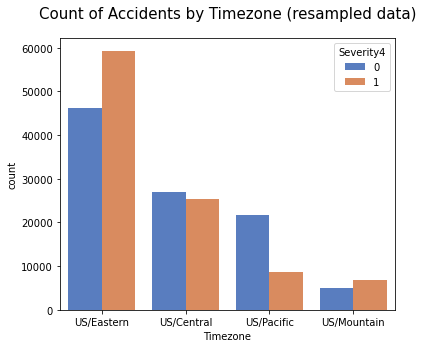

In [157]:
# timezone

plt.figure(figsize=(6,5))
chart = sns.countplot(x='Timezone', hue='Severity4', data=df_bl ,palette="muted")
plt.title("Count of Accidents by Timezone (resampled data)", size=15, y=1.05)
plt.show()

In [158]:
# frequency encoding
fre_list = ['Street', 'City', 'County', 'Zipcode', 'Airport_Code']
for i in fre_list:
    newname = i + '_Freq'
    df[newname] = df.groupby([i])[i].transform('count')
    df[newname] = df[newname]/df.shape[0]*df[i].unique().size
    df[newname] = df[newname].apply(lambda x: np.log(x+1))

In [160]:
df = df.drop(fre_list, axis  = 1)

In [161]:
# # weather features

df['Pressure_bc']= boxcox(df['Pressure(in)'].apply(lambda x: x+1),lmbda=6)
df['Visibility_bc']= boxcox(df['Visibility(mi)'].apply(lambda x: x+1),lmbda = 0.1)
df['Wind_Speed_bc']= boxcox(df['Wind_Speed(mph)'].apply(lambda x: x+1),lmbda=-0.2)
df = df.drop(['Pressure(in)','Visibility(mi)','Wind_Speed(mph)'], axis=1)


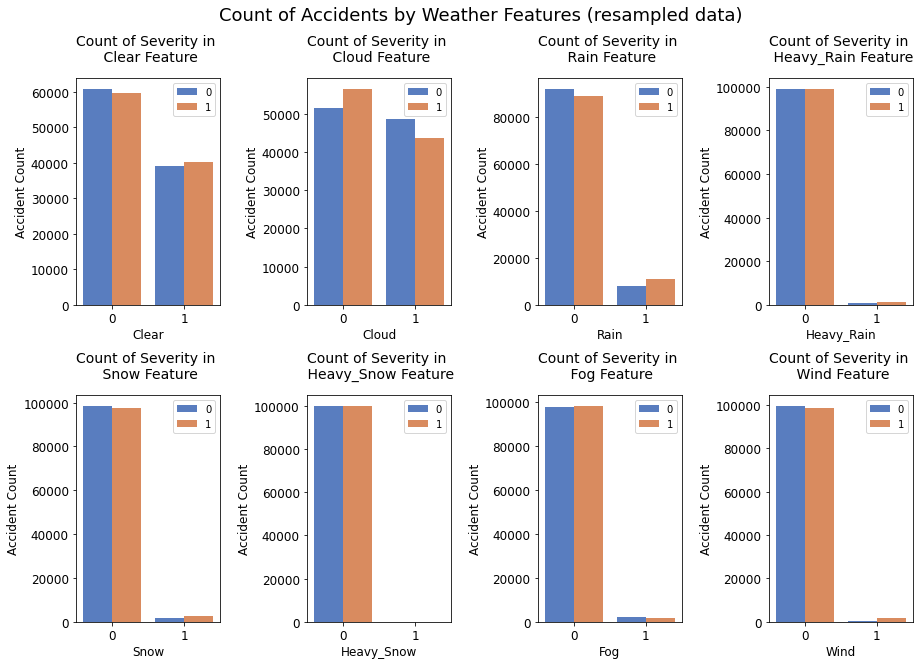

In [162]:
#weather conditions
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4,wspace = 0.6)
for i, feature in enumerate(weather, 1):    
    plt.subplot(2, 4, i)
    sns.countplot(x=feature, hue='Severity4', data=df_bl ,palette="muted")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(['0', '1'], loc='upper right', prop={'size': 10})
    plt.title('Count of Severity in \n {} Feature'.format(feature), size=14, y=1.05)
fig.suptitle('Count of Accidents by Weather Features (resampled data)', fontsize=18)
plt.show()

In [163]:
# # wind direction
# plt.figure(figsize=(10,5))
# chart = sns.countplot(x='Wind_Direction', hue='Severity4', data=df_bl ,palette="muted")
# plt.title("Count of Accidents in Wind Direction (resample data)", size=15, y=1.05)
# plt.show()

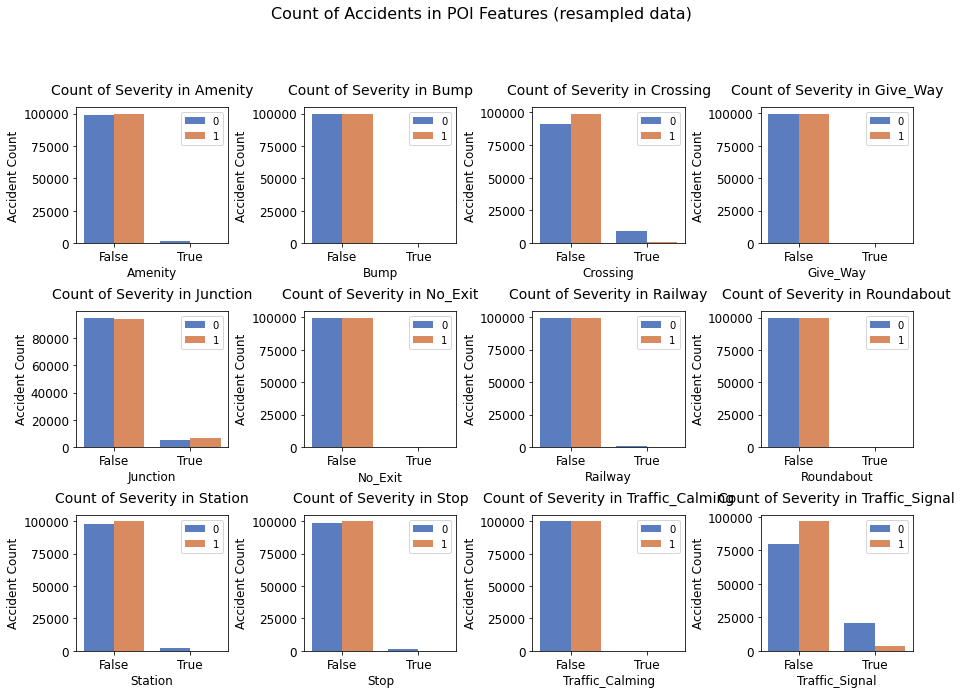

In [164]:
# poi features

POI_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(15, 10))

plt.subplots_adjust(hspace=0.5,wspace = 0.5)
for i, feature in enumerate(POI_features, 1):    
    plt.subplot(3, 4, i)
    sns.countplot(x=feature, hue='Severity4', data=df_bl ,palette="muted")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(['0', '1'], loc='upper right', prop={'size': 10})
    plt.title('Count of Severity in {}'.format(feature), size=14, y=1.05)
fig.suptitle('Count of Accidents in POI Features (resampled data)',y=1.02, fontsize=16)
plt.show()

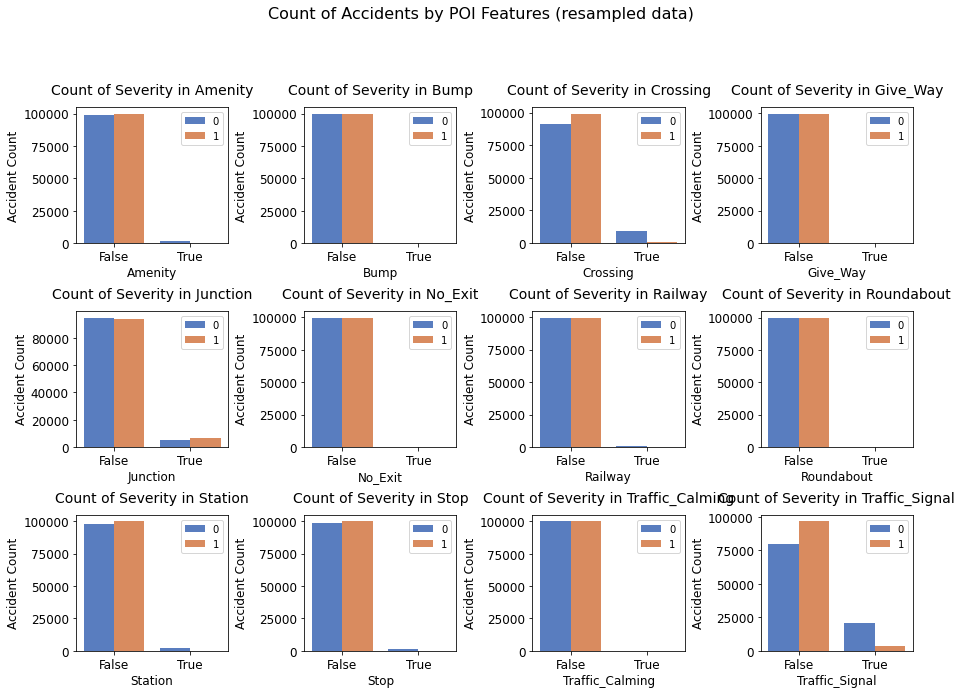

In [152]:
# poi features

POI_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(15, 10))

plt.subplots_adjust(hspace=0.5,wspace = 0.5)
for i, feature in enumerate(POI_features, 1):    
    plt.subplot(3, 4, i)
    sns.countplot(x=feature, hue='Severity4', data=df_bl ,palette="muted")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(['0', '1'], loc='upper right', prop={'size': 10})
    plt.title('Count of Severity in {}'.format(feature), size=14, y=1.05)
fig.suptitle('Count of Accidents by POI Features (resampled data)',y=1.02, fontsize=16)
plt.show()

In [165]:
#df = df.drop(['Pressure(in)','Visibility(mi)','Wind_Speed(mph)'], axis=1)

In [166]:
df= df.drop(['Bump','Give_Way','No_Exit','Roundabout','Traffic_Calming'], axis=1)

In [167]:
# df = df.drop(['Day','Minute','Population_County_log','City_Freq','Civil_Twilight_Night',
#               'Nautical_Twilight_Night'], axis=1)

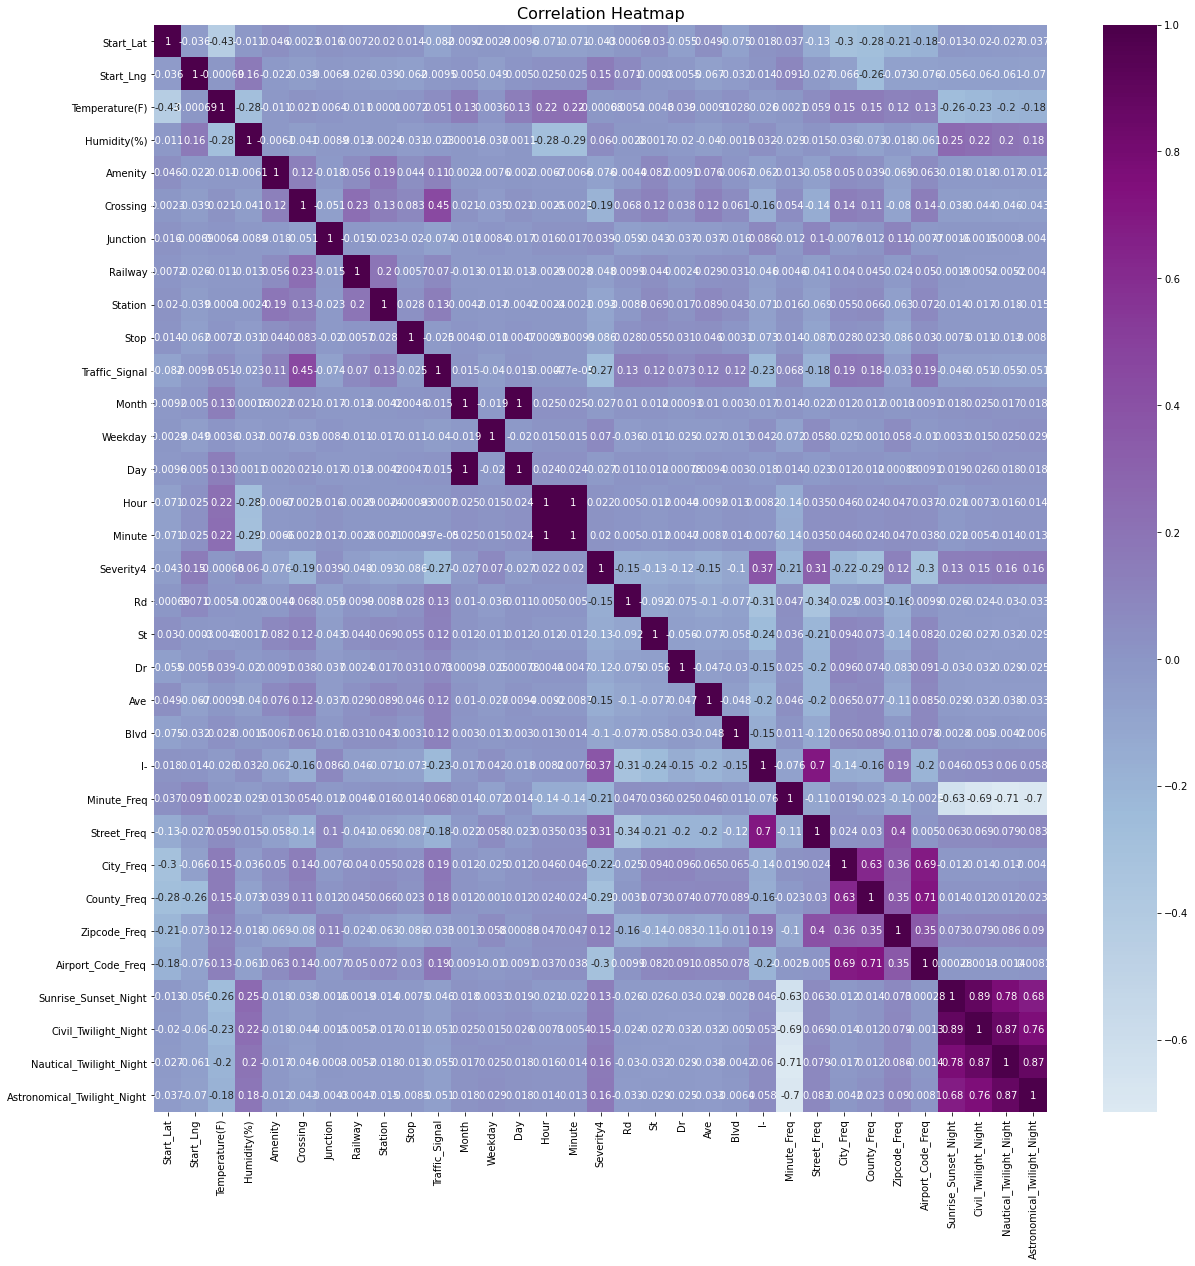

In [168]:
# see correlation
# one-hot encoding
df[period_features] = df[period_features].astype('category')
df = pd.get_dummies(df, columns=period_features, drop_first=True)

# resample again
df_bl = pd.concat([df[df['Severity4']==1].sample(40000, replace = True), 
                   df[df['Severity4']==0].sample(40000)], axis=0)

# plot correlation
df_bl['Severity4'] = df_bl['Severity4'].astype(int)
plt.figure(figsize=(20,20))
#cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(df_bl.corr(), annot=True,cmap='BuPu', center=0).set_title("Correlation Heatmap", fontsize=16)
plt.show()

In [169]:
df = df.drop(['Day','Minute','City_Freq','Civil_Twilight_Night',
              'Nautical_Twilight_Night'], axis=1)

In [170]:
# one hot encoding
df = df.replace([True, False], [1,0])

cat = ['Side','State','Timezone','Wind_Direction', 'Weekday', 'Month', 'Hour']
df[cat] = df[cat].astype('category')
df = pd.get_dummies(df, columns=cat, drop_first=True)

In [171]:
#df=df.drop(['Source','Start_Time','Year'], axis=1)
#df = df.drop(['Population_County','Transit_County','Walk_County'], axis = 1)
# df=df.drop(['Start_Time'], axis=1)
# df=df.drop(['Year'], axis=1)

In [172]:
df.head()

,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Amenity,Crossing,Junction,Railway,Station,Stop,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,39.865147,-84.058723,36.9,91.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39.928059,-82.831184,37.9,100.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,39.063148,-84.032608,36.0,100.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,39.747753,-84.205582,35.1,96.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,39.627781,-84.188354,36.0,89.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df.head()

,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Amenity,Crossing,Junction,Railway,Station,Stop,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,39.865147,-84.058723,36.9,91.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39.928059,-82.831184,37.9,100.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,39.063148,-84.032608,36.0,100.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,39.747753,-84.205582,35.1,96.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,39.627781,-84.188354,36.0,89.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#df.columns

In [79]:
#df.to_csv('df.csv')
print(df.columns)

Index(['Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)', 'Amenity',
       'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
       ...
       'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19',
       'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object', length=135)


In [173]:
df.head()

#df.columnsdf.head()

#df.columns

#df.to_csv('df.csv')
print(df.columns)#df.columns

In [174]:
#df.to_csv('df.csv')
print(df.columns)

Index(['Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)', 'Amenity',
       'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
       ...
       'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19',
       'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object', length=135)


### Model

In [175]:
# resample again
df_bl = pd.concat([df[df['Severity4']==1].sample(100000, replace = True), 
                   df[df['Severity4']==0].sample(100000)], axis=0)
# split X, y
X = df_bl.drop('Severity4', axis=1)
y= df_bl['Severity4']

# Standardizing the features based on unit variance
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

# split train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(\
  X, y, test_size=0.20, random_state=0)

In [176]:
#Grid Search
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
LR_grid = {
           'penalty':            ['none','l2'],
           'C':                  [0.001,.009,0.01,.09,1,5,10,25],
           'max_iter': [1000, 10000, 100000]
           }
CV_LR = GridSearchCV(estimator=LogisticRegression(random_state=0), param_grid = LR_grid,scoring = 'accuracy',cv=5)
CV_LR.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'max_iter': [1000, 10000, 100000],
                         'penalty': ['none', 'l2']},
             scoring='accuracy')

In [177]:
print('Best Parameters: ', CV_LR.best_params_)

Best Parameters:  {'C': 1, 'max_iter': 1000, 'penalty': 'l2'}


In [178]:
# # # Logistic regression
# # from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(max_iter=10000,random_state=42)
# clf.fit(X_train, y_train)

# accuracy_train = clf.score(X_train, y_train)
# print("Train Accuracy: %.1f%%"% (accuracy_train*100))
# accuracy_test = clf.score(X_test,y_test)
# print("Test Accuracy: %.1f%%"% (accuracy_test*100))

In [204]:
from sklearn.metrics import confusion_matrix, accuracy_score
CV_LR_clf = LogisticRegression(C=1, max_iter=1000, penalty='l2')
CV_LR_clf.fit(X_train, y_train)
accuracy_train = CV_LR_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (accuracy_train*100))
accuracy_test = CV_LR.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (accuracy_test*100))

Train Accuracy: 79.2%
Test Accuracy: 79.4%


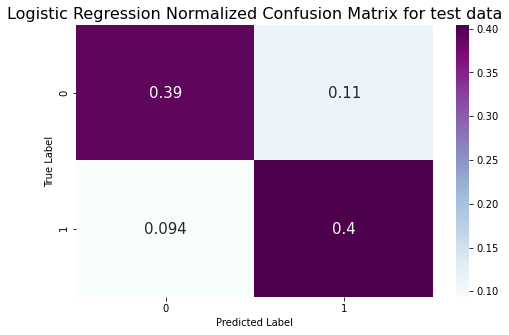

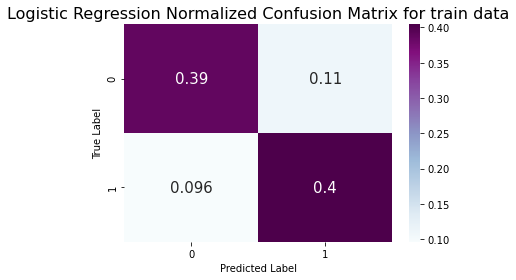

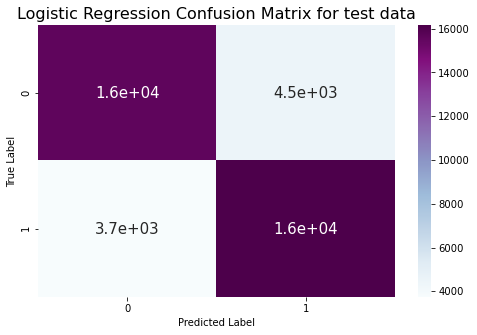

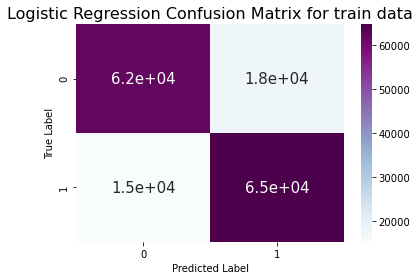

In [205]:
from sklearn.metrics import confusion_matrix

prediction_test = CV_LR_clf.predict(X_test)
prediction_train = CV_LR_clf.predict(X_train)


confmat1 = confusion_matrix(y_true=y_test, y_pred=prediction_test)
confmat2 = confusion_matrix(y_true=y_train, y_pred=prediction_train)

# conf_matrix = np.array(pd.DataFrame(data=confmat[0],
#                            columns=['0','1'],index=['0','1']))
plt.figure(figsize = (8,5))
sns.heatmap((confmat1/np.sum(confmat1)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Logistic Regression Normalized Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap((confmat2/np.sum(confmat2)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Logistic Regression Normalized Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize = (8,5))
sns.heatmap(confmat1, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Logistic Regression Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap(confmat2, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Logistic Regression Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [181]:
# conf_matrix/np.sum(conf_matrix)

In [182]:
#confmat

In [183]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
DT_grid = { 'min_samples_split': [5,10, 20, 30, 40], 
          'max_features': [None, 'log2', 'sqrt']}
CV_DT = GridSearchCV(DecisionTreeClassifier(random_state=0), DT_grid, verbose=1, cv=5)
CV_DT.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.2min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_split': [5, 10, 20, 30, 40]},
             verbose=1)

In [87]:
print('Best Parameters: ', CV_DT.best_params_)

Best Parameters:  {'max_features': 'sqrt', 'min_samples_split': 5}


In [184]:
print('Best Parameters: ', CV_DT.best_params_)

Best Parameters:  {'max_features': None, 'min_samples_split': 5}


In [207]:
#from sklearn import tree
# Training step, on X_train with y_train
tree_clf = DecisionTreeClassifier(min_samples_split = 5,max_features= 'sqrt' )
tree_clf = tree_clf.fit(X_train,y_train)

tree_accuracy_train = tree_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (tree_accuracy_train*100))
tree_accuracy_test = tree_clf.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (tree_accuracy_test*100))

Train Accuracy: 100.0%
Test Accuracy: 97.3%


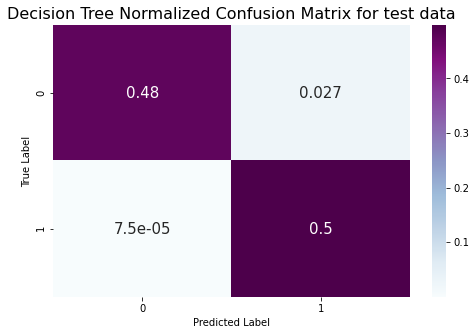

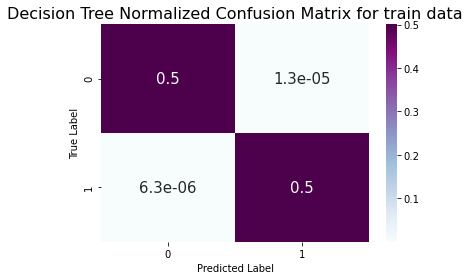

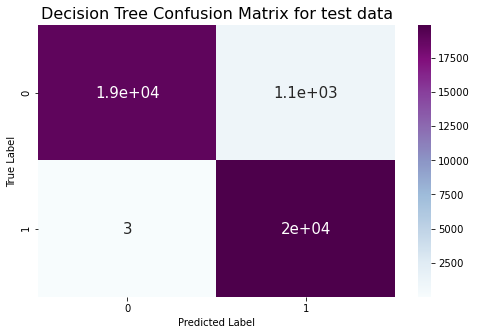

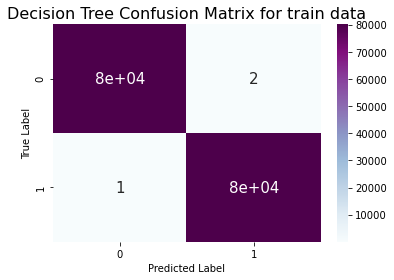

In [208]:
prediction_test = tree_clf.predict(X_test)
prediction_train = tree_clf.predict(X_train)

#confmat = confusion_matrix(y_true=y_test, y_pred=prediction)


confmat1 = confusion_matrix(y_true=y_test, y_pred=prediction_test)
confmat2 = confusion_matrix(y_true=y_train, y_pred=prediction_train)

# conf_matrix = np.array(pd.DataFrame(data=confmat[0],
#                            columns=['0','1'],index=['0','1']))
plt.figure(figsize = (8,5))
sns.heatmap((confmat1/np.sum(confmat1)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Decision Tree Normalized Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap((confmat2/np.sum(confmat2)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Decision Tree Normalized Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize = (8,5))
sns.heatmap(confmat1, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Decision Tree Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap(confmat2, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Decision Tree Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

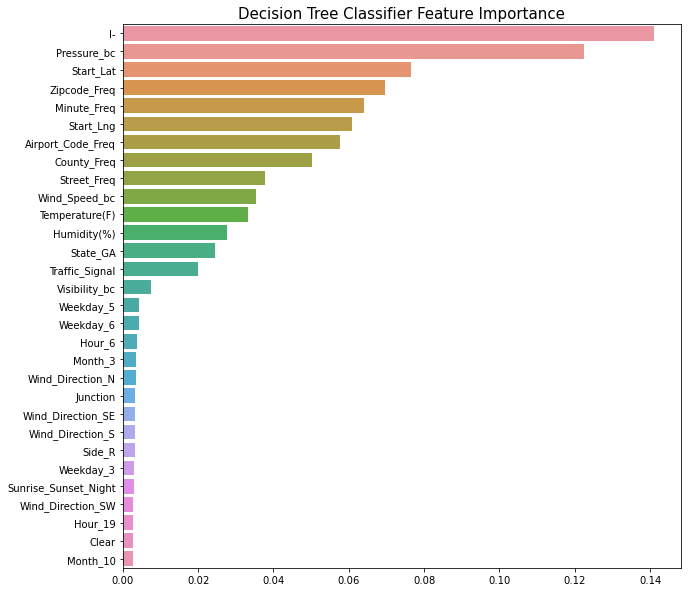

In [88]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=['importance'], 
                           index=df.drop('Severity4',axis=1).columns)

importances.iloc[:,0] = tree_clf.feature_importances_

importances.sort_values(by='importance', inplace=True, ascending=False)
importances30 = importances.head(30)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y=importances30.index, data=importances30)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Decision Tree Classifier Feature Importance', size=15)

plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 10))
# tree.plot_tree(tree_clf, max_depth=4, fontsize=10,
#                feature_names=df.drop('Severity4',axis =1).columns.to_list(),
#                class_names = True, filled=True)
# plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators'     : [30,40,50],
    'max_depth'        : [20,30,40]
}
CV_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,cv=4)
CV_clf.fit(X_train, y_train)

In [93]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=['importance'], 
                           index=df.drop('Severity4',axis=1).columns)

importances.iloc[:,0] = tree_clf.feature_importances_

importances.sort_values(by='importance', inplace=True, ascending=False)
importances30 = importances.head(30)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y=importances30.index, data=importances30)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Decision Tree Classifier Feature Importance', size=15)

plt.show()

# fig, ax = plt.subplots(figsize=(20, 10))
# tree.plot_tree(tree_clf, max_depth=4, fontsize=10,
#                feature_names=df.drop('Severity4',axis =1).columns.to_list(),
#                class_names = True, filled=True)
# plt.show()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators'     : [30,40,50],
    'max_depth'        : [20,30,40]
}
CV_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,cv=4)
CV_clf.fit(X_train, y_train)# fig, ax = plt.subplots(figsize=(20, 10))
# tree.plot_tree(tree_clf, max_depth=4, fontsize=10,
#                feature_names=df.drop('Severity4',axis =1).columns.to_list(),
#                class_names = True, filled=True)
# plt.show()

In [188]:
# fig, ax = plt.subplots(figsize=(20, 10))
# tree.plot_tree(tree_clf, max_depth=4, fontsize=10,
#                feature_names=df.drop('Severity4',axis =1).columns.to_list(),
#                class_names = True, filled=True)
# plt.show()

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators'     : [30,40,50],
    'max_depth'        : [20,30,40]
}
CV_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,cv=4)
CV_clf.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [20, 30, 40],
                         'n_estimators': [30, 40, 50]})

In [190]:
print('Best Parameters: ', CV_clf.best_params_)

Best Parameters:  {'max_depth': 40, 'n_estimators': 40}


In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier(max_depth=40,n_estimators=40)
rf_clf.fit(X_train,y_train)

rf_accuracy_train = rf_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (rf_accuracy_train*100))
rf_accuracy_test = rf_clf.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (rf_accuracy_test*100))

Train Accuracy: 100.0%
Test Accuracy: 98.9%


In [192]:
# f = lambda x: 1 if x>=0.5 else 0
# train_pred = np.array(list(map(f, rf_clf.predict(X_train))))
# test_pred = np.array(list(map(f, rf_clf.predict(X_test))))
# tree_clf = RandomForestClassifier(min_samples_split = 5,max_features= 'sqrt' )
# tree_clf = tree_clf.fit(X_train,y_train)

# rf_train_accuracy = accuracy_score(y_train, train_pred)
# print("Train Accuracy: %.1f%%"% (rf_train_accuracy*100))
# rf_test_accuracy = accuracy_score(y_test, test_pred)
# print("Test Accuracy: %.1f%%"% (rf_test_accuracy*100))

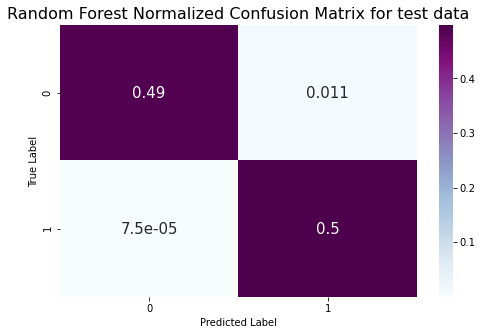

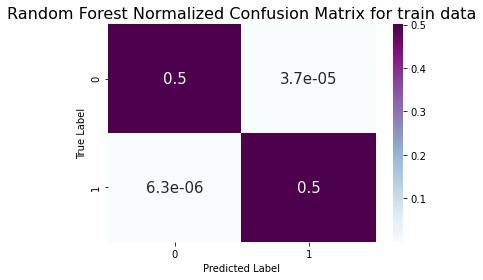

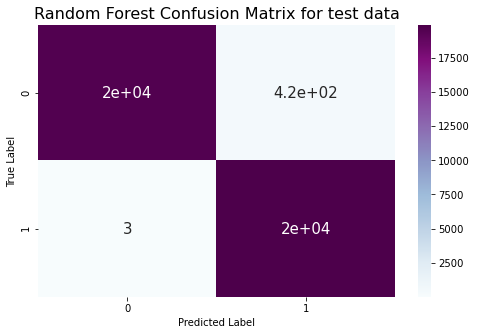

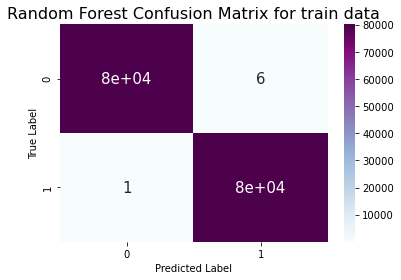

In [194]:
prediction_test = rf_clf.predict(X_test)
prediction_train = rf_clf.predict(X_train)

#confmat = confusion_matrix(y_true=y_test, y_pred=prediction)


confmat1 = confusion_matrix(y_true=y_test, y_pred=prediction_test)
confmat2 = confusion_matrix(y_true=y_train, y_pred=prediction_train)

# conf_matrix = np.array(pd.DataFrame(data=confmat[0],
#                            columns=['0','1'],index=['0','1']))
plt.figure(figsize = (8,5))
sns.heatmap((confmat1/np.sum(confmat1)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Random Forest Normalized Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap((confmat2/np.sum(confmat2)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Random Forest Normalized Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize = (8,5))
sns.heatmap(confmat1, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Random Forest Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap(confmat2, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Random Forest Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

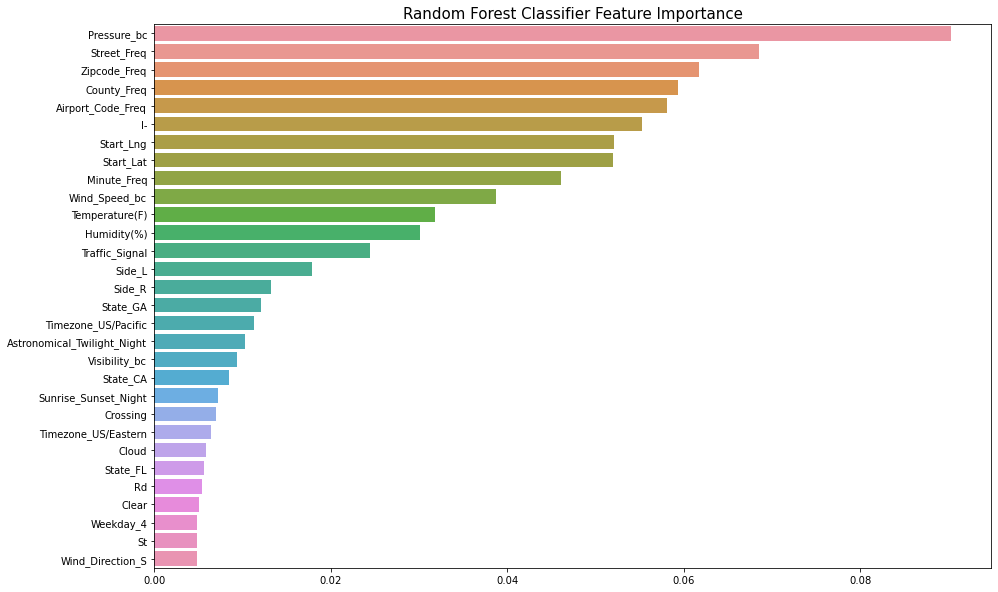

In [85]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=['importance'], index=df.drop('Severity4',axis=1).columns)

importances.iloc[:,0] = rf_clf.feature_importances_

importances.sort_values(by='importance', inplace=True, ascending=False)
importances30 = importances.head(30)

plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y=importances30.index, data=importances30)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Random Forest Classifier Feature Importance', size=15)

plt.show()

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# param_grid = { 
#     'n_neighbors'     : [1,5,10,15,20]
# }
# CV_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid,cv=5)
# CV_knn.fit(X_train, y_train)

In [ ]:
# print('Best Parameters: ', CV_knn.best_params_)

In [ ]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=['importance'], index=df.drop('Severity4',axis=1).columns)

importances.iloc[:,0] = rf_clf.feature_importances_

importances.sort_values(by='importance', inplace=True, ascending=False)
importances30 = importances.head(30)

plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y=importances30.index, data=importances30)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Random Forest Classifier Feature Importance', size=15)

plt.show()


In [196]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators'     : [30,40,50],
    'max_depth'        : [2,3,4]
}
CV_gb = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid,cv=4)
CV_gb.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4], 'n_estimators': [30, 40, 50]})

In [197]:
print('Best Parameters: ', CV_gb.best_params_)

Best Parameters:  {'max_depth': 4, 'n_estimators': 50}


In [200]:
gb_clf = GradientBoostingClassifier(max_depth=4,n_estimators=50)
gb_clf.fit(X_train,y_train)

gb_accuracy_train = gb_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (gb_accuracy_train*100))
gb_accuracy_test = gb_clf.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (gb_accuracy_test*100))

Train Accuracy: 80.9%
Test Accuracy: 81.0%


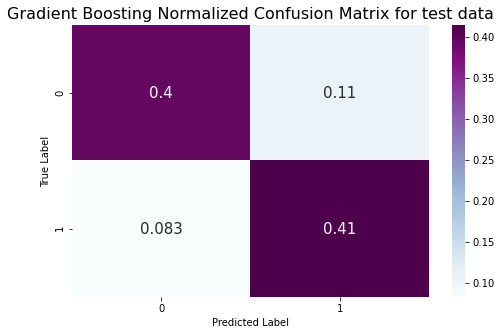

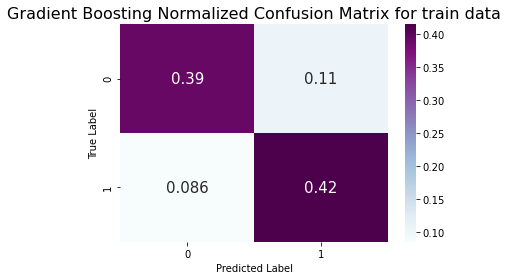

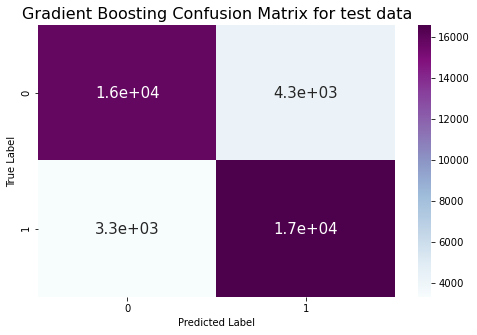

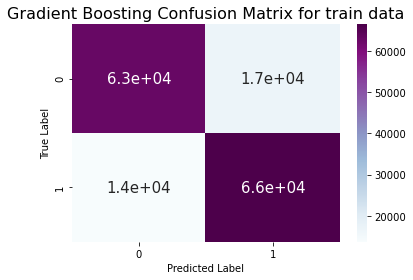

In [201]:
prediction_test = gb_clf.predict(X_test)
prediction_train = gb_clf.predict(X_train)

#confmat = confusion_matrix(y_true=y_test, y_pred=prediction)


confmat1 = confusion_matrix(y_true=y_test, y_pred=prediction_test)
confmat2 = confusion_matrix(y_true=y_train, y_pred=prediction_train)

# conf_matrix = np.array(pd.DataFrame(data=confmat[0],
#                            columns=['0','1'],index=['0','1']))
plt.figure(figsize = (8,5))
sns.heatmap((confmat1/np.sum(confmat1)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Gradient Boosting Normalized Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap((confmat2/np.sum(confmat2)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Gradient Boosting Normalized Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize = (8,5))
sns.heatmap(confmat1, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Gradient Boosting Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap(confmat2, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Gradient Boosting Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [198]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators'     : [30,40,50]
}
CV_ab = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid,cv=4)
CV_ab.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [30, 40, 50]})

In [199]:
print('Best Parameters: ', CV_ab.best_params_)

Best Parameters:  {'n_estimators': 50}


In [202]:
ab_clf = AdaBoostClassifier(n_estimators=50)
ab_clf.fit(X_train,y_train)

ab_accuracy_train = ab_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (ab_accuracy_train*100))
ab_accuracy_test = ab_clf.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (ab_accuracy_test*100))

Train Accuracy: 79.3%
Test Accuracy: 79.7%


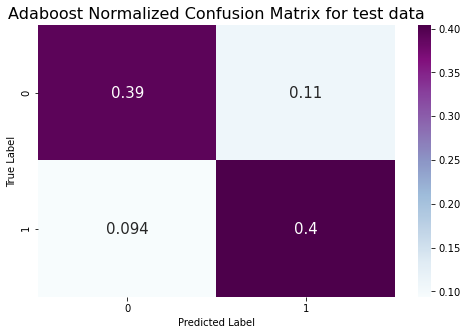

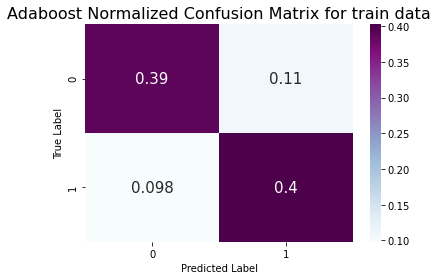

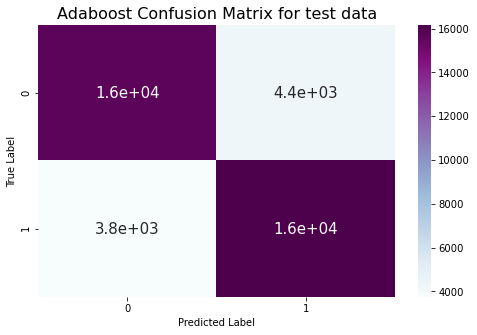

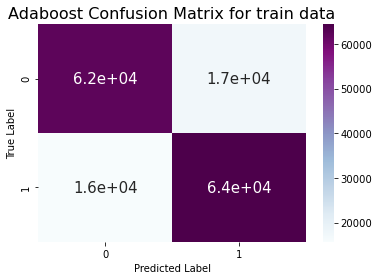

In [203]:
prediction_test = ab_clf.predict(X_test)
prediction_train = ab_clf.predict(X_train)

#confmat = confusion_matrix(y_true=y_test, y_pred=prediction)


confmat1 = confusion_matrix(y_true=y_test, y_pred=prediction_test)
confmat2 = confusion_matrix(y_true=y_train, y_pred=prediction_train)

# conf_matrix = np.array(pd.DataFrame(data=confmat[0],
#                            columns=['0','1'],index=['0','1']))
plt.figure(figsize = (8,5))
sns.heatmap((confmat1/np.sum(confmat1)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Adaboost Normalized Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap((confmat2/np.sum(confmat2)), annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Adaboost Normalized Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize = (8,5))
sns.heatmap(confmat1, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Adaboost Confusion Matrix for test data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

sns.heatmap(confmat2, annot=True,cmap="BuPu",annot_kws={"fontsize":15}).set_title(
    "Adaboost Confusion Matrix for train data", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
#confmat

In [ ]:
#conf_matrix